# Object Detection
In this notebook, state-of-the-art models for object detection are used on some example images. First, Faster R-CNN will be covered. Subsequently, YOLO will be used for object detection.

In [1]:
# Imports
import cv2
import torch
import argparse
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

c:\python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Faster R-CNN


The pre-trained Faster R-CNN model will be loaded here. The model has a ResNet50 base network and will be loaded from the torchvision module. The min_size argument denotes the minimum dimensions of the bounding boxes that surround the objects. Making this value smaller will result in more small object to be detected.  

In [2]:
# Load pretrained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size=800)

# This model is trained to detect the following classes
coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

### Predicting the Object Classes
A function is written to detect objects and predict its classes and bounding boxes with the pre-trained Faster R-CNN. The torchvision model takes as input an image in the form of a tensor with dimensions [batch_size x channels x height x width]. Therefore the image needs to be transformed to a tensor. 

In [3]:
# Define transform
transform = transforms.ToTensor()

In [4]:
# Prediction function
def predict(image, model, detection_threshold):
    
    # Process the image
    image = transform(image)
    image = image.unsqueeze(0) # adding a batch dimension because we only work with single images

    # Predict
    outputs = model(image) 

    # Print outputs
    print(f"Boxes: {outputs[0]['boxes']}")
    print(f"Labels: {outputs[0]['labels']}")
    print(f"Scores: {outputs[0]['scores']}")

    # Get all the predicted class labels
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].numpy()]

    # Get all the scores for the predicted objects
    pred_scores = outputs[0]['scores'].detach().numpy()

    # Get all the predicted bounding boxes
    pred_bboxes = outputs[0]['boxes'].detach().numpy()

    # If the score is above the pre-defined threshold, then the bounding box is considered
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)

    return boxes, pred_classes, outputs[0]['labels']

### Drawing the Bounding Box
A function is written here to draw the bounding boxes around the detected objects in the image. In the image there can be many objects of different classes. Therefore, bounding boxes of similar classes need to have the same colour. This helps in visualising of the detections. 

In [5]:
# Define colors
COLORS = np.random.uniform(0,255,size=(len(coco_names),3)) # 3 dimensional vectors for each label is created, the values range between 0 and 255

In [6]:
def draw_boxes(boxes, classes, labels, image):

    # Read the image with OpenCV
    image = cv2.cvtColor(np.asarray(image), cv2.COLOR_BGR2RGB)

    # Loop over all bounding boxes and draw them on the image
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        start_x = int(box[0])
        start_y = int(box[1])
        end_x = int(box[2])
        end_y = int(box[3])
        cv2.rectangle(image,(start_x,start_y),(end_x,end_y),color,2) 
        cv2.putText(image,classes[i],(start_x,start_y-5), cv2.FONT_HERSHEY_SIMPLEX,0.8,color,2) 

    return image

### Results

The Faster R-CNN model will be now used with the above defined functions to perform object detection on 3 image examples. The Faster R-CNN model detects all the objects within the image. A bounding box is placed around the objects. These are annotated with only the class name.

In [7]:
# Define image files
images_ex = ['../../data/horses.jpg','../../data/people.jpg','../../data/street.jpg']

# Set model in evaluation mode
ret = model.eval()

Image example 1:

Boxes: tensor([[281.8719,  79.2813, 420.7068, 225.9756],
        [330.9540,  80.9836, 593.0887, 228.4178],
        [109.6095,  95.4174, 332.9263, 226.0391],
        [111.1189, 108.3176, 299.6678, 226.6196],
        [359.3415,  98.2549, 600.4445, 232.9423],
        [142.3595,  82.4780, 474.7162, 232.5669],
        [217.1381,  91.9967, 338.9270, 226.1555],
        [111.3002, 108.9321, 300.2285, 223.7775],
        [346.2999,  14.0223, 632.1669, 213.3479],
        [351.5599, 123.3582, 592.3282, 229.2103]], grad_fn=<StackBackward0>)
Labels: tensor([19, 19, 19, 18, 18, 19, 19, 21,  1, 22])
Scores: tensor([0.9977, 0.9913, 0.9898, 0.2787, 0.1807, 0.1448, 0.1275, 0.0993, 0.0854,
        0.0730], grad_fn=<IndexBackward0>)


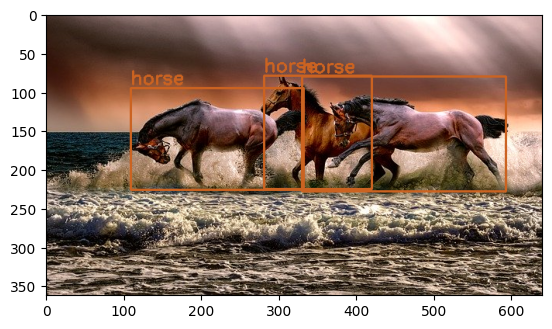

In [8]:
image = Image.open(images_ex[0])
boxes, classes, labels = predict(image,model,0.8)
image = draw_boxes(boxes,classes,labels,image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Image example 2:

Boxes: tensor([[ 838.6357,  332.8714,  931.3898,  610.8370],
        [ 235.5437,  160.7106,  430.6570,  690.1385],
        [1036.0818,  286.9706, 1156.6217,  604.0552],
        [ 718.0005,  406.3850,  778.0783,  582.8207],
        [ 490.6573,  387.9689,  557.2424,  599.1245],
        [ 762.8723,  405.6624,  821.9858,  584.3357],
        [ 608.5616,  386.3053,  668.2618,  598.7283],
        [ 455.2066,  407.0004,  505.5714,  588.4600],
        [ 572.2787,  409.2901,  619.7392,  594.0986],
        [ 654.2797,  413.5543,  704.2627,  587.6580],
        [ 376.1682,  346.8564,  469.2232,  622.5775],
        [ 184.0398,  191.8036,  311.2569,  613.2949],
        [ 869.4252,  368.6361,  920.3806,  477.0749],
        [ 463.3396,  441.3141,  502.3931,  502.6068],
        [ 685.6665,  444.3586,  713.8293,  519.5699],
        [1125.1451,  457.0602, 1159.7242,  500.2275],
        [ 179.3643,  366.9853,  238.8592,  446.9797],
        [1077.9030,  328.4338, 1087.2566,  336.9096],
        [ 606.8297,  

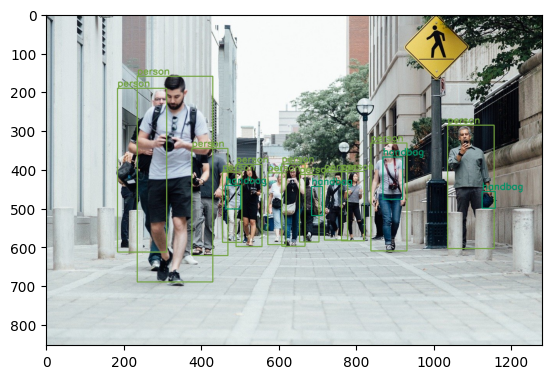

In [9]:
image = Image.open(images_ex[1])
boxes, classes, labels = predict(image,model,0.8)
image = draw_boxes(boxes,classes,labels,image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

Image example 3:

Boxes: tensor([[5.8550e+02, 3.0679e+02, 7.6959e+02, 7.9109e+02],
        [6.1061e+02, 5.0469e+02, 7.7416e+02, 8.3717e+02],
        [3.5637e+02, 3.8366e+02, 4.2221e+02, 4.4126e+02],
        [3.7229e-01, 4.1606e+02, 2.8784e+01, 4.6788e+02],
        [5.5278e+02, 3.9554e+02, 5.7382e+02, 4.6087e+02],
        [2.5864e+01, 4.2121e+02, 6.5340e+01, 4.4425e+02],
        [8.1940e+02, 3.7355e+02, 8.4451e+02, 4.4950e+02],
        [1.5357e+02, 3.3876e+02, 4.9642e+02, 6.5111e+02],
        [1.3568e+02, 4.1083e+02, 1.4943e+02, 4.4751e+02],
        [9.4219e+02, 3.0277e+02, 9.6331e+02, 3.2791e+02],
        [6.9452e+01, 4.1938e+02, 1.1694e+02, 4.4502e+02],
        [2.4149e+01, 4.2302e+02, 4.6692e+01, 4.4643e+02],
        [1.1634e+03, 3.8943e+02, 1.2014e+03, 4.3058e+02],
        [1.1246e+03, 3.8154e+02, 1.1546e+03, 4.3327e+02],
        [1.0262e+03, 3.8537e+02, 1.0831e+03, 4.3714e+02],
        [7.7204e+02, 3.7843e+02, 7.9312e+02, 4.2867e+02],
        [1.0726e+03, 3.8711e+02, 1.1134e+03, 4.3559e+02],
       

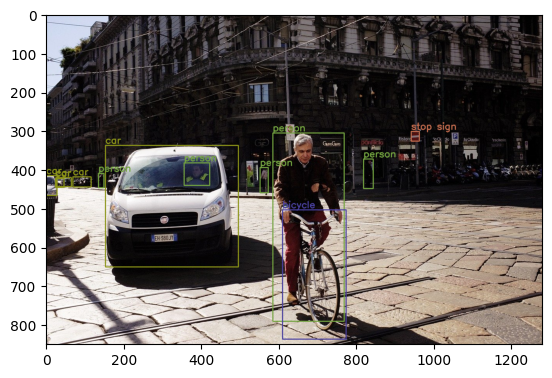

In [10]:
image = Image.open(images_ex[2])
boxes, classes, labels = predict(image,model,0.8)
image = draw_boxes(boxes,classes,labels,image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

## YOLO

The pre-trained YOLO v5 model will be loaded here from ultralytics. But first install the model requirements in your virtual environment: pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

In [11]:
# Load pretrained Faster R-CNN model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\matth/.cache\torch\hub\ultralytics_yolov5_master


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'setuptools>=65.5.1'] not found, attempting AutoUpdate...


requirements:  AutoUpdate skipped (offline)


YOLOv5  2023-9-1 Python-3.9.0 torch-1.11.0+cu113 CPU



Fusing layers... 


YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients


Adding AutoShape... 


### Results
Some images from ultralytics are loaded here to perform object detection on. 

In [12]:
# Load images    
image1 = cv2.imread('../../data/zidane.jpg')
image2 = cv2.imread('../../data/bus.jpg')

### Results
The YOLO v5 model is now used to perform object detection on the 2 downloaded image examples. Batch interference is used. The YOLO v5 model detects all the objects within the image. A bounding box is placed around the objects. These are annotated with the class name and probability.

image 1/2: 720x1280 2 persons, 1 tie
image 2/2: 1080x810 4 persons, 1 bus
Speed: 11.0ms pre-process, 346.3ms inference, 2.5ms NMS per image at shape (2, 3, 640, 640)


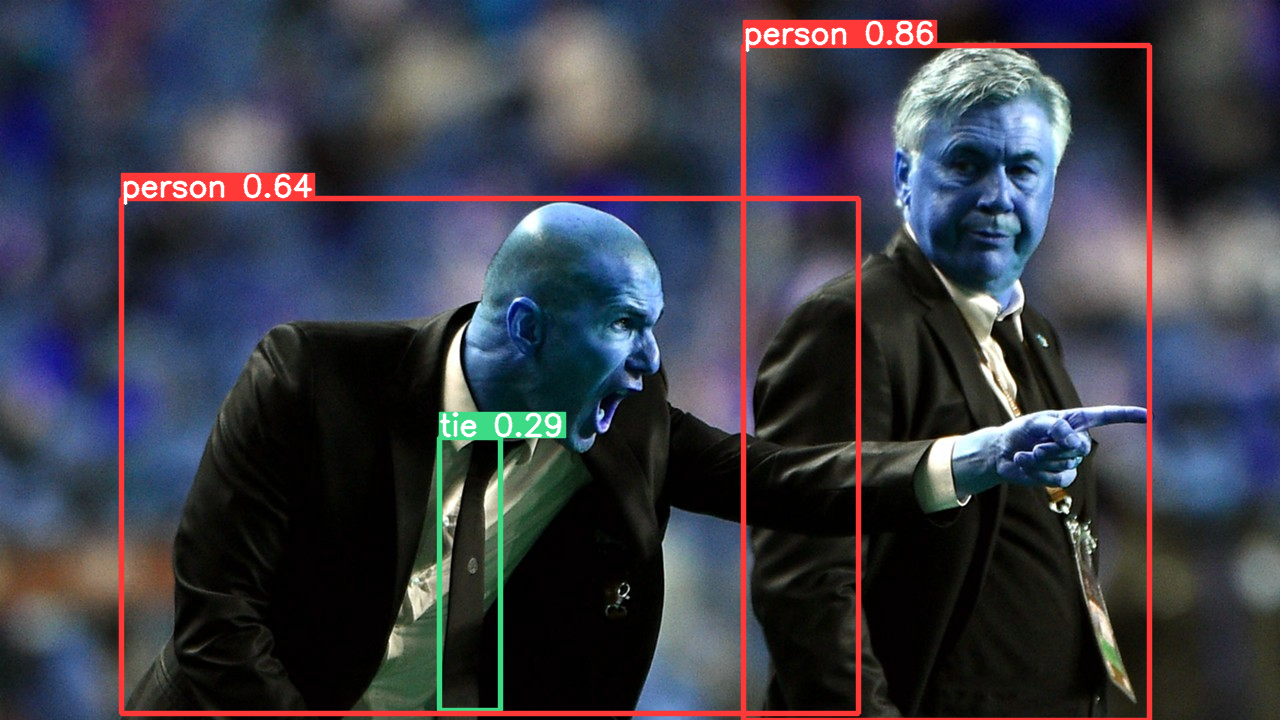

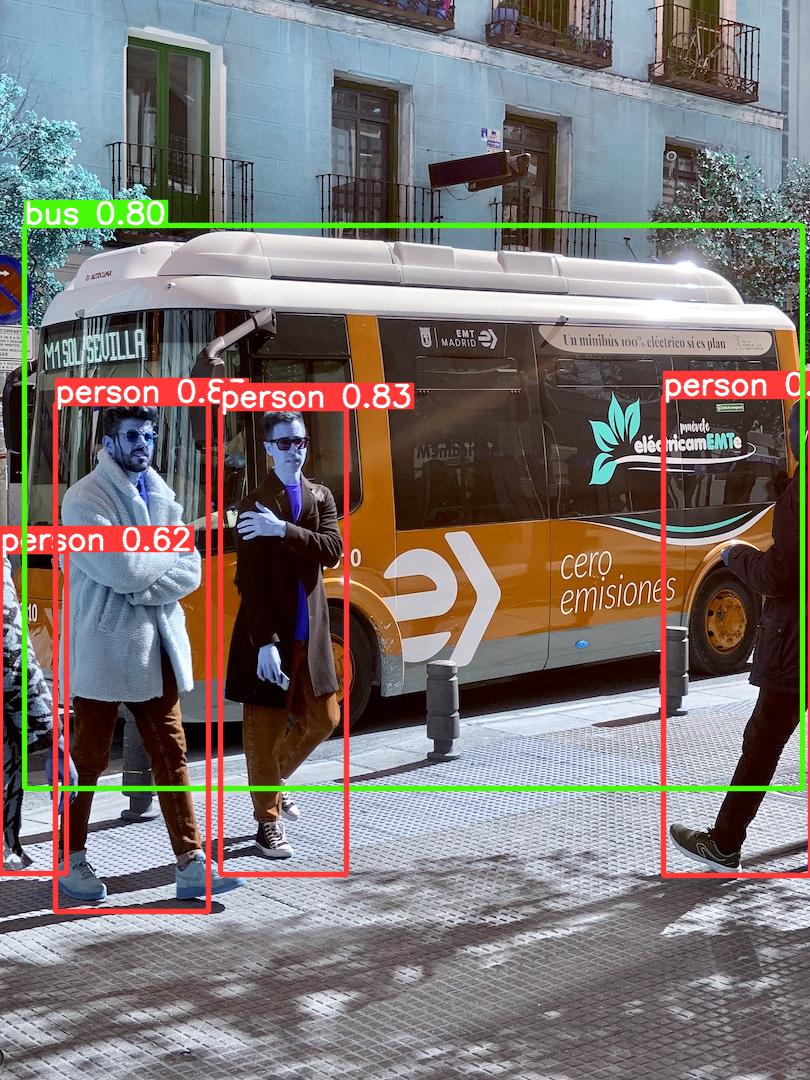

In [13]:
# Get predictions
results = model([image1, image2]) # size = batch of images
results.print()  
results.show()